In [1]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 9.4MB/s 
     |████████████████████████████████| 890kB 29.5MB/s 
     |████████████████████████████████| 1.1MB 20.3MB/s 
     |████████████████████████████████| 3.8MB 59.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/198-roBERTa_base/'

## Dependencies

In [5]:
import json, glob, warnings
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras import layers
from tensorflow.keras.models import Model

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [7]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,train,train,validation,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,train,validation,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [8]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

with open(MODEL_BASE_PATH + 'config.json') as json_file:
     config = json.load(json_file)

config

{'BATCH_SIZE': 32,
 'EPOCHS': 7,
 'ES_PATIENCE': 2,
 'LEARNING_RATE': 3e-05,
 'MAX_LEN': 64,
 'N_FOLDS': 5,
 'base_model_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-tf_model.h5',
 'config_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-config.json',
 'question_size': 4}

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h11 = hidden_states[-2]
    
    x = layers.Dropout(.1)(h11)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Make predictions

In [0]:
for n_fold in range(config['N_FOLDS']):
    n_fold +=1

    # Load data                               
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Load model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

# Model evaluation

In [12]:
#@title
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.763569,0.723412,0.040158,0.777398,0.723019,0.769425,0.724958,0.749782,0.720206,0.777647,0.729706,0.743594,0.719170
Sentiment negative,0.621020,0.548569,0.072451,0.647988,0.554063,0.630575,0.543058,0.595927,0.533306,0.646714,0.570856,0.583897,0.541564
Sentiment neutral,0.977845,0.975643,0.002202,0.978596,0.974230,0.978354,0.975818,0.977406,0.978849,0.978957,0.972271,0.975911,0.977045
Sentiment positive,0.605514,0.543730,0.061784,0.624978,0.539360,0.615213,0.553378,0.584101,0.542712,0.626422,0.548634,0.576855,0.534565
0 <= text tokens < 3,0.960362,0.951822,0.008540,0.955752,0.942623,0.964444,0.943548,0.954545,0.964286,0.965368,0.937500,0.961702,0.971154
3 <= text tokens < 15,0.811672,0.782119,0.029553,0.821025,0.786153,0.819119,0.777101,0.802631,0.778581,0.820823,0.783426,0.794764,0.785333
15 <= text tokens < 30,0.733990,0.687653,0.046337,0.750010,0.688628,0.739492,0.688576,0.714816,0.693808,0.752578,0.687540,0.713054,0.679713
30 <= text tokens < 45,0.707191,0.654754,0.052437,0.727041,0.641278,0.711918,0.669842,0.694728,0.626289,0.723056,0.687609,0.679210,0.648752
45 <= text tokens < 120,0.799080,0.787406,0.011674,0.826047,0.853867,0.732034,0.984403,0.855693,0.670685,0.825725,0.724624,0.755899,0.703449


# Visualize predictions

In [13]:
#@title
k_fold['jaccard_mean'] = (k_fold['jaccard_fold_1'] + k_fold['jaccard_fold_2'] + 
                          k_fold['jaccard_fold_3'] + k_fold['jaccard_fold_4'] + 
                          k_fold['jaccard_fold_4']) / 5

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean']].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,1.000000
2,my boss is bullying me...,bullying me,negative,6,2,0.166667,0.333333
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000
4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,17,4,0.214286,1.000000
5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,27,27,1.000000,0.966667
6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,17,1,0.071429,1.000000
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000
8,both of you,both of you,neutral,3,3,1.000000,1.000000
9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,19,7,0.500000,0.840000


## Post-processing evaluation

In [14]:
#@title
k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
print('\nImpute neutral')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
print('\nImpute <= 3')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute noise')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
print('\nImpute neutral and <= 3')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute neutral and <= 3 and mpute noise')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))


Impute neutral


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.769307,0.730378,0.038930,0.781944,0.729066,0.776065,0.733142,0.756234,0.726467,0.782059,0.737675,0.750234,0.725538



Impute <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.761548,0.722422,0.039126,0.775452,0.723143,0.767634,0.724865,0.747690,0.718015,0.775251,0.726731,0.741710,0.719356



Impute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.762270,0.722346,0.039924,0.776130,0.721655,0.768153,0.723655,0.748451,0.719041,0.776326,0.728905,0.742290,0.718472



Impute neutral and <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.767064,0.729118,0.037946,0.779854,0.729252,0.774061,0.732615,0.753871,0.724074,0.779490,0.734174,0.748044,0.725476



Impute neutral and <= 3 and mpute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.765796,0.728089,0.037706,0.778632,0.727888,0.772789,0.731498,0.752587,0.722909,0.778184,0.733372,0.746786,0.724779


# Error analysis

## 10 worst predictions

In [23]:
#@title
k_fold['jaccard_mean'] = (k_fold['jaccard_fold_1'] + k_fold['jaccard_fold_2'] + 
                          k_fold['jaccard_fold_3'] + k_fold['jaccard_fold_4'] + 
                          k_fold['jaccard_fold_4']) / 5

display(k_fold[['text', 'selected_text', 'sentiment', 'jaccard', 'jaccard_mean', 
                'prediction_fold_1', 'prediction_fold_2', 'prediction_fold_3', 
                'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

,text,selected_text,sentiment,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
9550,another interview... please somebody hire me?! but i`m late,please somebody hire me?!,negative,0.444444,0.0,but i`m late,but i`m late,late,but i`m late,but i`m late
25749,that gave me a great smile. nice way to end the day. you are so right,nice,positive,0.062500,0.0,great smile.,great smile.,great smile.,great smile.,great smile.
25744,ahh im in love. hes theeee best.,best.,positive,0.142857,0.0,ahh im in love.,ahh im in love.,ahh im in love.,ahh im in love.,ahh im in love.
6004,"goodmorning tweedles very happy mood, i think i will always be after this past weekend. lol vids of the `beyonce we...",goodmorning,positive,0.045455,0.0,,"very happy mood,",happy,very happy,"very happy mood,"
23796,ooo enjoy and thanks for looking out for ours,d thanks,positive,0.111111,0.0,enjoy,enjoy,enjoy,enjoy,enjoy
1234,my legs are so **** sore. and my feet hurt to walk. whataday,hurt to,negative,0.166667,0.0,my legs are so **** sore.,my legs are so **** sore.,my legs are so **** sore.,my legs are so **** sore.,my legs are so **** sore.
8003,such a headache it`s killen me!,it`s killen me!,negative,0.500000,0.0,headache,headache,headache,headache,such a headache
1244,"haha.. you were actually in violations of someone`s trademark?! okay.. yeah, i went to bed at 4 and i had to be up ...","yeah, i went to bed at 4 and i had to be up at 6. :[",negative,0.565217,0.0,violations,violations,violations,violations,violations
25729,"thanks hon, doing great and yourself? happy mothers day",happy,positive,0.111111,0.0,thanks,thanks,thanks,thanks,thanks
25719,"nice on the jet ski testing! hope the book is going well. cheers for adding me, got twitter after watching the gadge...","hope the book is going well. cheers for adding me,",positive,0.476190,0.0,nice,nice,nice,nice,nice


# Sentiment

In [24]:
#@title
print('\n sentiment == neutral')
display(k_fold[k_fold['sentiment'] == 'neutral'][['text', 'selected_text', 
                                                  'jaccard_mean', 'prediction_fold_1', 
                                                  'prediction_fold_2', 'prediction_fold_3', 
                                                  'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == positive')
display(k_fold[k_fold['sentiment'] == 'positive'][['text', 'selected_text', 
                                                   'jaccard_mean', 'prediction_fold_1', 
                                                   'prediction_fold_2', 'prediction_fold_3', 
                                                   'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == negative')
display(k_fold[k_fold['sentiment'] == 'negative'][['text', 'selected_text', 
                                                   'jaccard_mean', 'prediction_fold_1', 
                                                   'prediction_fold_2', 'prediction_fold_3', 
                                                   'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))


 sentiment == neutral


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
12306,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.",bad,0.045455,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows."
22331,i am the queen of losing things. important things like keycards and bus passes.,losing,0.071429,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.
4045,"morning john, yes i do, however i have a diary clash and sadly can`t attend!",sadly,0.071429,"morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!"
9712,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow",shame,0.090909,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow"
4944,sick right now very thankful for my chicken soup and my bed!,sick,0.090909,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!
6851,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?",disintegrating?,0.100000,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?"
25766,lol...i am greedy. i`m craving coldstone again.,m greedy.,0.125000,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.
23037,"work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube",mad blocking,0.142857,"work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites!


 sentiment == positive


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
15399,yes! haha and then when he impaled himself with the crossed keys! love scottish-trying-to-be-irish ewan mcgregor,haha,0.0,love,love,love,love,love
24060,want: trip to boston next month. need: addit`l motivation to save the $ to do so. beloved daughter wants to go with...,want:,0.0,motivation,motivation,beloved,beloved,
17632,"re-dyed the hair, early start tomorrow heading down to londons clothes show, great place to be when i feel fat. br...",= motivation,0.0,great,great,great,great,great
1640,so ur moomie liked the pandora? you can buy me one next lol,lol,0.0,liked,liked,liked,liked,liked
5626,hi thanks for the follow good luck with your friend? ha,good luck,0.0,hi thanks,thanks,thanks,hi thanks,thanks
9014,"-i don`t have a ticket, my boyfriend isn`t that into them, it might rain, and i`m on a budget...boo! i <3 tho",i`m on a budget...boo!,0.0,i <3,i <3,i <3,..boo! i <3,i <3
5674,thanks. feel so happy 2 make ur day a great one. enjoy it 2 the fullest n have fun always,enjoy,0.0,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy
23796,ooo enjoy and thanks for looking out for ours,d thanks,0.0,enjoy,enjoy,enjoy,enjoy,enjoy
18266,where can i get nice food for mam down the bay that a) is likely to have room for 3 tonight and b) isn`t the mingin`...,food,0.0,nice,nice,nice,nice,nice
8884,"nuuuuu, i totally love may, it`s the best for me cos i was born in may",the best for me,0.0,love,i totally love,i totally love,i totally love,i totally love



 sentiment == negative


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
19682,"'isn`t she lovely? isn`t she beautiful?' sorry stevie, you`re not really in a position to make that judgement #stev...",you`re not really in a position to make that judgement,0.0,sorry,sorry,sorry,sorry,sorry
16881,"yeah, tried it. no go.",tried,0.0,no go.,no go.,no go.,no go.,tried it. no go.
23654,sad day... told my students this is my last year here... a lot of crying since..,crying,0.0,sad day...,sad,sad,sad day...,sad day...
12244,my body is aching. i can barely move...but its worth it to be champs,barely,0.0,my body is aching.,my body is aching.,my body is aching.,my body is aching.,my body is aching.
25319,"yeah, that does sound a bit bad man... i got **** exam week this week",i got **** exam week this week,0.0,bad,bad,bad,bad,bad
13285,bit devastated that i lost my entire documents folder on my home computer.,lost,0.0,devastated,devastated,devastated,devastated,devastated
561,"i bet its cool down in sr, huh? it`s not here. i haven`t stopped sweating since noon when dad and i were packing",huh?,0.0,it`s not here.,i haven`t stopped sweating,it`s not here. i haven`t stopped sweating,it`s not here.,it`s not here. i haven`t stopped sweating
5696,shud realy go 2 bed proper tired bt cnt b boverd...x,t cnt b boverd.,0.0,tired,proper tired,tired,tired,proper tired
21902,: sorry forgot that,forgot,0.0,sorry,sorry,sorry,sorry,sorry
15210,plus it hurts seeing sum1 you love falling for someone else! not even kidding im wellllllllllllll gutted. **** ****,im wellllllllllllll gutted.,0.0,hurts,hurts,hurts,hurts,hurts


# text_tokenCnt

In [25]:
#@title
print('\n text_tokenCnt <= 3')
display(k_fold[k_fold['text_tokenCnt'] <= 3][['text', 'selected_text', 'sentiment', 
                                              'jaccard_mean', 'prediction_fold_1', 
                                              'prediction_fold_2', 'prediction_fold_3', 
                                              'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

print('\n text_tokenCnt >= 45')
display(k_fold[k_fold['text_tokenCnt'] >= 45][['text', 'selected_text',  'sentiment', 
                                               'jaccard_mean', 'prediction_fold_1', 
                                               'prediction_fold_2', 'prediction_fold_3', 
                                               'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 text_tokenCnt <= 3


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
12073,so bored...,so bored..,negative,0.266667,so bored...,so bored...,bored...,so bored...,so bored...
11774,loving my boys,loving my boys,positive,0.333333,loving,loving,loving,loving,loving
7798,happy bank holiday,happy bank holiday,positive,0.333333,happy,happy,happy,happy,happy
21012,misses driving already,misses driving already,negative,0.333333,misses,misses,misses,misses,misses
5990,twitter you suck,twitter you suck,negative,0.333333,suck,suck,suck,suck,suck



 text_tokenCnt >= 45


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
1741,hey wow cheers for the insight ppl looks fun oh im just stunned..it`s aweomse!!! (robluketic live > http://ustre...,cheers,positive,0.000000,looks fun,,looks fun,looks fun,looks fun
20243,*sigh* off 2 bed 2 try 2 get these crummy 2 hrs of sleep b4 my horrid 12 hour day..smh. niterzzz evry1. don`t let th...,bite..,negative,0.036364,crummy,crummy,horrid,horrid 12 hour day..smh. niterzzz evry1. don`t let the twitterbugz bite..,
5058,"oh ffs :@ a don`t get paid till monday :@:@:@ :$. sorry william, gonna have to wait till next weekend till i give yo...","sorry william, gonna have to wait till next weekend ti",negative,0.100000,sorry,sorry,sorry,sorry,sorry
24299,"iigghhtt, just fur geet it. idc. idk. eh blah ugh. blah idk... hah..=] um yah.. immboredddd, ugh ill just fuckitt","immboredddd,",negative,0.131111,"immboredddd, ugh ill just fuckitt",ugh ill just fuckitt,"iigghhtt, just fur geet it. idc. idk. eh blah ugh. blah idk... hah..=] um yah.. immboredddd, ugh ill just fuckitt","immboredddd, ugh ill just fuckitt","immboredddd, ugh ill just fuckitt"
13276,"ahhh! i knowww! i saw it may 5th and 6th in newcastle and it was so good!!! i`m soo excited for 6th june, as its my...","! i`m soo excited for 6th june, as its my bday aswell!",positive,0.208571,so good!!! i`m soo excited,so good!!! i`m soo excited,so good!!! i`m soo excited,was so good!!! i`m soo excited,i`m soo excited


# selected_text_tokenCnt

In [26]:
#@title
print('\n selected_text_tokenCnt <= 3')
display(k_fold[k_fold['selected_text_tokenCnt'] <= 3][['text', 'selected_text',  'sentiment', 
                                                       'jaccard_mean', 'prediction_fold_1', 
                                                       'prediction_fold_2', 'prediction_fold_3', 
                                                       'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))
print('\n selected_text_tokenCnt >= 45')
display(k_fold[k_fold['selected_text_tokenCnt'] >= 45][['text', 'selected_text',  'sentiment', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 selected_text_tokenCnt <= 3


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
16881,"yeah, tried it. no go.",tried,negative,0.0,no go.,no go.,no go.,no go.,tried it. no go.
8731,happy mother`s day to my sweet mum,sweet mum,positive,0.0,happy,happy,happy,happy,happy
2739,"****, we have some kind of bugs in our house. and we dont know why or what it is",bugs,negative,0.0,"****,","****,","****,","****,","****,"
9087,wtf? twitter doesnt support messages from my phone -i wanted to be able to twit while on vacay. poo on you twitter,doesnt support me,negative,0.0,wtf?,wtf?,wtf?,wtf?,wtf?
14845,"that`s family for you imna crash, woke up 630 3 days in a row....lol",a crash,negative,0.0,"imna crash,","imna crash,","crash,","imna crash,","imna crash,"



 selected_text_tokenCnt >= 45


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
23800,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m... ? http://blip.fm/~5jucn,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m... ? http://blip.fm/~5jucn,neutral,0.675000,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m...,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m...
19705,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,negative,0.822222,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,..ppl`s tears kill me!,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,..ppl`s tears kill me!
106,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave so...,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me,neutral,0.912088,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave
25700,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67ha,neutral,0.916667,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...
16076,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u kat...,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u kath,neutral,0.918667,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u kat...,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u k,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss


# Jaccard histogram

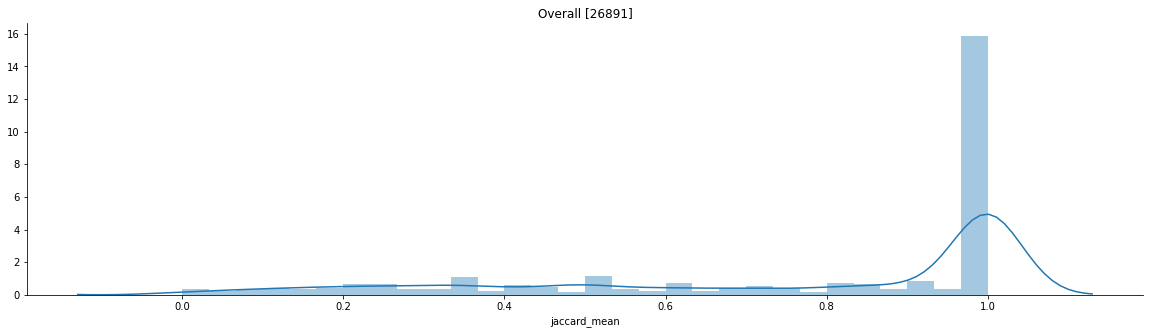

In [27]:
#@title
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(k_fold['jaccard_mean'], ax=ax).set_title(f"Overall [{len(k_fold)}]")
sns.despine()
plt.show()

## By sentiment

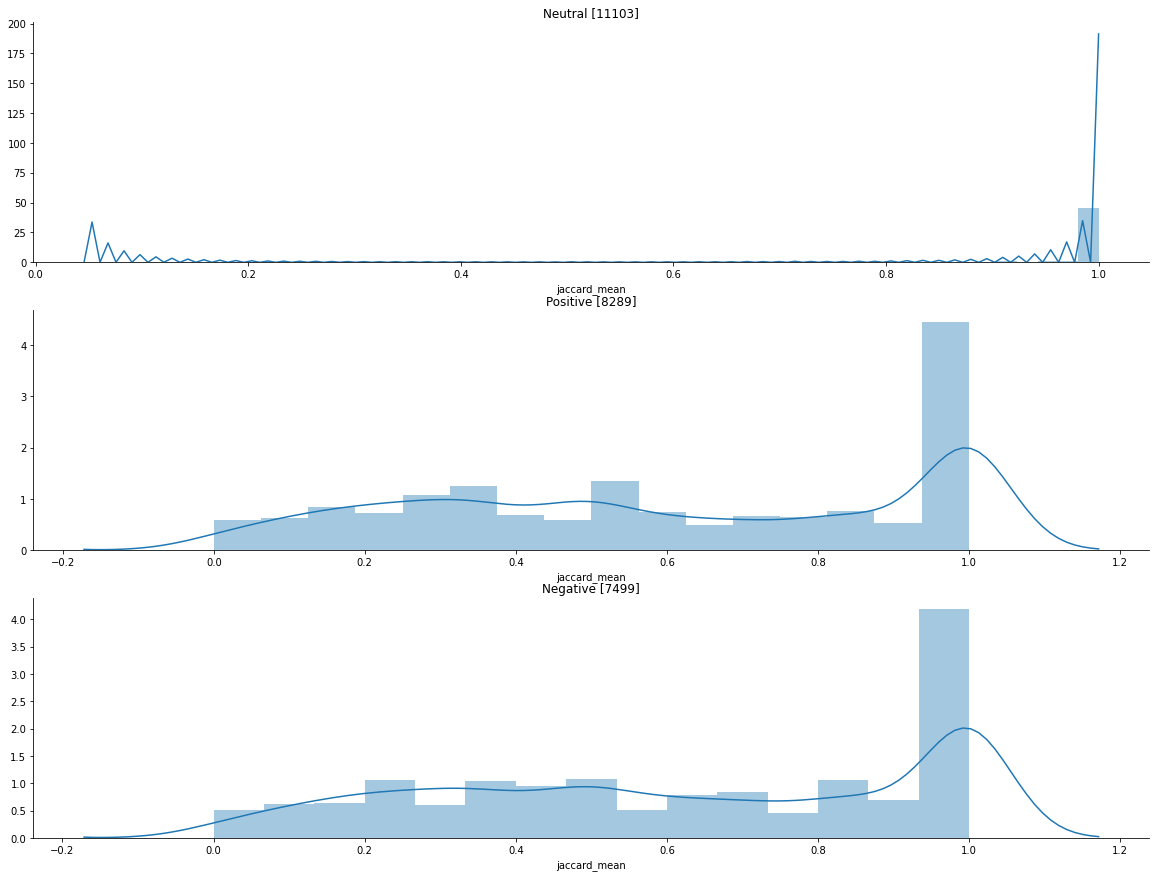

In [28]:
#@title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=False)
sns.distplot(k_fold[k_fold['sentiment'] == 'neutral']['jaccard_mean'], ax=ax1).set_title(f"Neutral [{len(k_fold[k_fold['sentiment'] == 'neutral'])}]")
sns.distplot(k_fold[k_fold['sentiment'] == 'positive']['jaccard_mean'], ax=ax2).set_title(f"Positive [{len(k_fold[k_fold['sentiment'] == 'positive'])}]")
sns.distplot(k_fold[k_fold['sentiment'] == 'negative']['jaccard_mean'], ax=ax3).set_title(f"Negative [{len(k_fold[k_fold['sentiment'] == 'negative'])}]")
sns.despine()
plt.show()

## By text token count

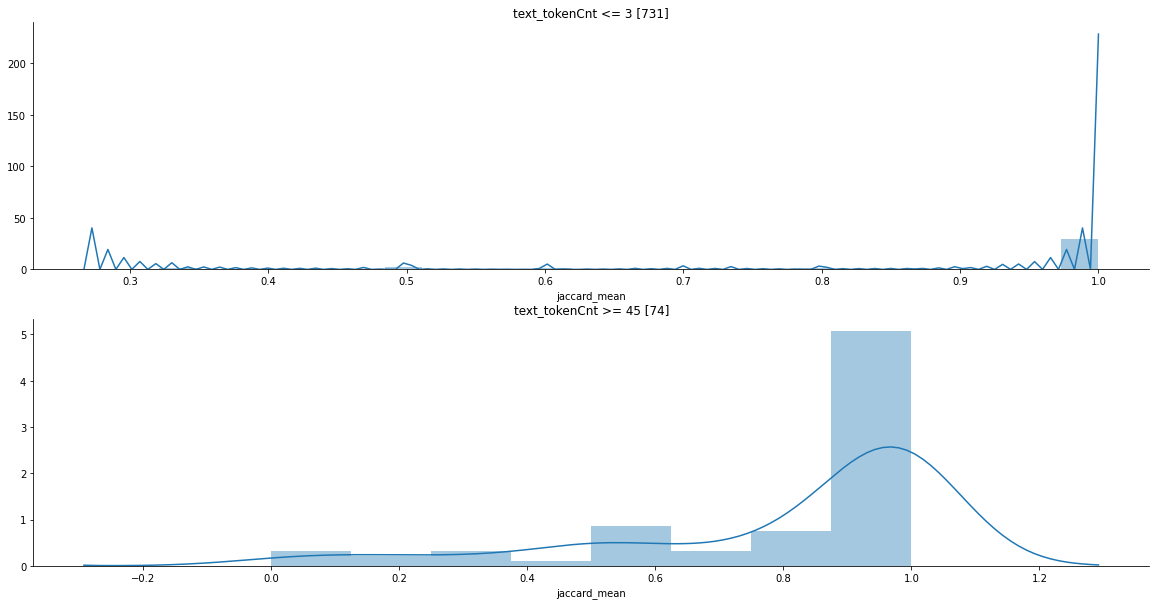

In [29]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold[k_fold['text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"text_tokenCnt <= 3 [{len(k_fold[k_fold['text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold[k_fold['text_tokenCnt'] >= 45]['jaccard_mean'], ax=ax2).set_title(f"text_tokenCnt >= 45 [{len(k_fold[k_fold['text_tokenCnt'] >= 45])}]")
sns.despine()
plt.show()

## By selected_text token count

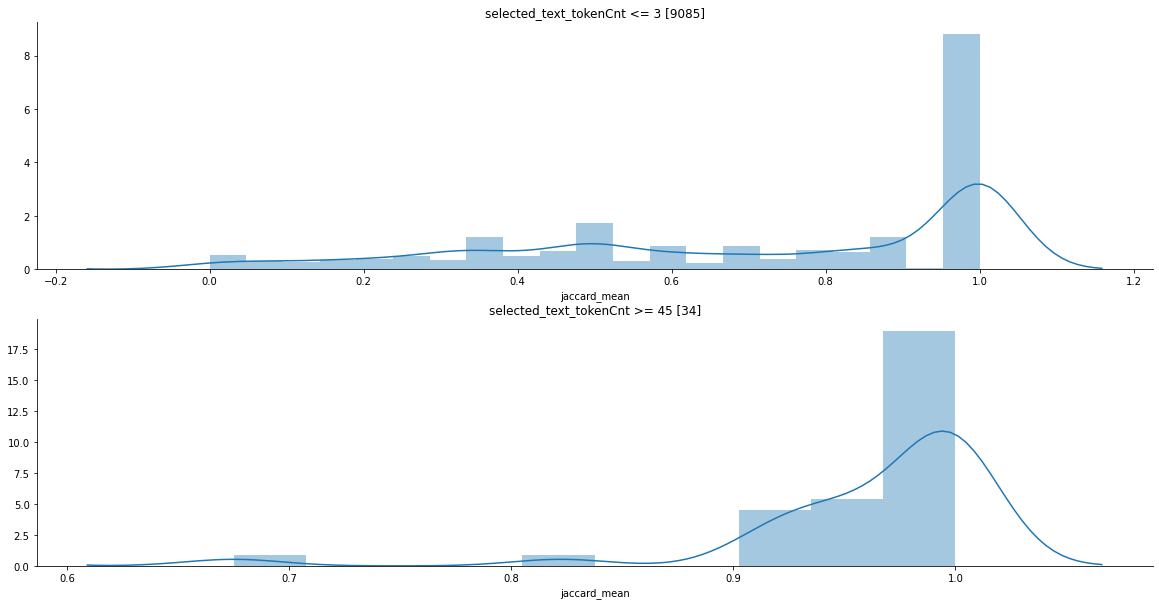

In [30]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold[k_fold['selected_text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"selected_text_tokenCnt <= 3 [{len(k_fold[k_fold['selected_text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold[k_fold['selected_text_tokenCnt'] >= 45]['jaccard_mean'], ax=ax2).set_title(f"selected_text_tokenCnt >= 45 [{len(k_fold[k_fold['selected_text_tokenCnt'] >= 45])}]")
sns.despine()
plt.show()